# Dogs vs. Cats Redux: Kernels Edition

## Initial configuration

Show plots in the web page itself:

In [1]:
# Define path to data.
%matplotlib inline 

# Define path to data.
path = "data/" 

In [2]:
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


## Using a pretrained VGG model with the vgg16 class to finetune Dogs vs Cat model

In [11]:
from vgg16 import Vgg16

vgg = Vgg16()
batch_size = 64

In [4]:
vgg.model.load_weights(path + 'results/ft1.h5')

In [12]:
batches = vgg.get_batches(path + 'train', batch_size = batch_size)
valid_batches = vgg.get_batches(path + 'valid', batch_size = batch_size)

vgg.finetune(batches)
vgg.fit(batches, valid_batches, nb_epoch = 1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 617s - loss: 0.1153 - acc: 0.9698 - val_loss: 0.0662 - val_acc: 0.9825


In [13]:
vgg.model.save_weights(path + 'results/ft1.h5')

## Prediction

In [14]:
test_batch_size = 4
test_batches = vgg.get_batches(path + 'sample/test2', batch_size = test_batch_size)

Found 10 images belonging to 1 classes.


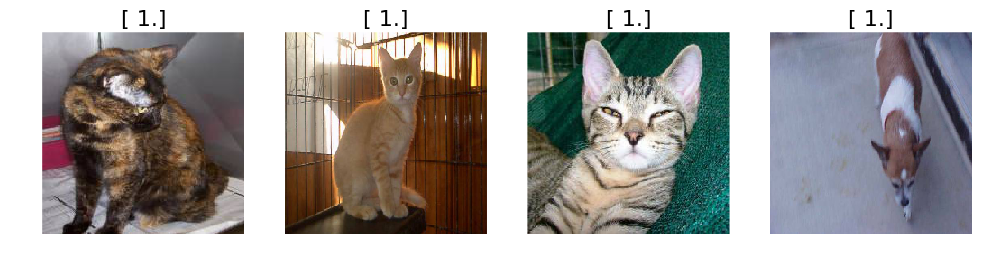

In [15]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles = test_labels)

In [16]:
vgg.predict(test_imgs, True)

(array([ 1.    ,  1.    ,  1.    ,  0.6211], dtype=float32),
 array([0, 0, 0, 1]),
 ['cats', 'cats', 'cats', 'dogs'])

## Submit to Kaggle

In [22]:
import numpy as np

In [17]:
batches, preds = vgg.test(path + 'test', batch_size = batch_size * 2)

Found 12500 images belonging to 1 classes.


In [18]:
filenames = batches.filenames

Get second column of predictions array:

In [19]:
is_dog = preds[:, 1]
is_dog[:5]

array([  1.4996e-09,   6.2112e-01,   3.2526e-07,   3.5009e-12,   1.0000e+00], dtype=float32)

Get ids of images:

In [20]:
ids = [int(f[8:f.find('.')]) for f in filenames]
ids[:5]

[9292, 12026, 9688, 4392, 779]

Put 2 columns next to each other:

In [25]:
subm = np.stack([ids, is_dog], axis = 1)
subm[:5]

array([[  9.2920e+03,   1.4996e-09],
       [  1.2026e+04,   6.2112e-01],
       [  9.6880e+03,   3.2526e-07],
       [  4.3920e+03,   3.5009e-12],
       [  7.7900e+02,   1.0000e+00]])

Save subm as a CSV file:

In [27]:
np.savetxt('data/subm1.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

In [28]:
from IPython.display import FileLink
FileLink('data/subm1.csv')

/home/ubuntu/nbs/courses/deeplearning1/nbs/personal/dogs-vs-cats-redux/data/subm1.csv